### Simple time series forecasting comparison between LSTM (encoder-decoder) and LSTM Attention architecture

In this notebook, I would like to do time series analysis using time series data and compare the performance of LSTM (encoder-decoder) and LSTM Attention architecture. 

The data has been collected from kaggle competition (https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)



In [91]:
## import the required packages
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd
import sklearn.preprocessing
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose


In [105]:
## loading data
df = pd.read_csv('DOM_hourly.csv', parse_dates=['Datetime'])
df.head()


,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [106]:
df.describe()

,DOM_MW
count,116189.000000
mean,10949.203625
std,2413.946569
min,1253.000000
25%,9322.000000
50%,10501.000000
75%,12378.000000
max,21651.000000


In [107]:
df.isna().sum()


Datetime    0
DOM_MW      0
dtype: int64

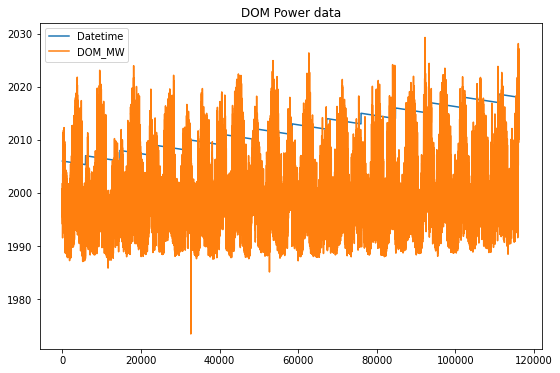

In [108]:
## visaulize the data
df.plot(figsize=(9,6),legend=True)

plt.title('DOM Power data')

plt.show()


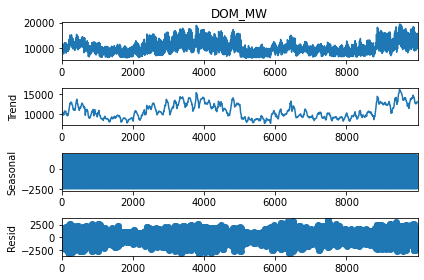

In [110]:
decompose_result_mult = seasonal_decompose(pd.Series(df['DOM_MW'][:10000]), model="additive", period=24)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [111]:
#normalizg data
scaler = sklearn.preprocessing.MinMaxScaler()
df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))


In [112]:
## since I am going run it in colab notebook, I took a small slice of the data to model

x = np.array(df['DOM_MW'][:10000])

In [113]:
##
train_ratio = 0.7
train_len = int(train_ratio * x.shape[0])
print(train_len)


7000


In [114]:
x_index = np.array(range(len(x)))


In [115]:
x1_detrend = x #- x1_trend

x_lbl = np.column_stack([x1_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)


(10000, 3)
[[3.98862634e-01 0.00000000e+00 1.00000000e+00]
 [3.83223845e-01 1.00000000e+00 1.00000000e+00]
 [3.79841161e-01 2.00000000e+00 1.00000000e+00]
 ...
 [7.12618884e-01 9.99700000e+03 0.00000000e+00]
 [6.97519365e-01 9.99800000e+03 0.00000000e+00]
 [6.89724483e-01 9.99900000e+03 0.00000000e+00]]


In [116]:
def truncate(x, feature_cols=range(2), target_cols=range(2), label_col=2, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_lbl, feature_cols=range(2), target_cols=range(2), 
                            label_col=2, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)


(9781, 200, 2) (9781, 20, 2) (9781,)


In [117]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)


(6800, 200, 2) (6800, 20, 2)
(2981, 200, 2) (2981, 20, 2)


In [118]:
n_hidden = 20 #number ber of hidden units
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)


KerasTensor(type_spec=TensorSpec(shape=(None, 200, 1), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [119]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)


KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), name='lstm_7/strided_slice_3:0', description="created by layer 'lstm_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), name='lstm_7/while:4', description="created by layer 'lstm_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), name='lstm_7/while:5', description="created by layer 'lstm_7'")


In [120]:
##Apply Batch normalization
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)


In [121]:
#Decoder
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])


In [122]:
out = TimeDistributed(Dense(output_train.shape[1]))(decoder)


In [50]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 1)]     0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 20),         1760        ['input_1[0][0]']                
                                 (None, 20),                                                      
                                 (None, 20)]                                                      
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 20)          80          ['lstm_2[0][0]']                 
 rmalization)                                                                               

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


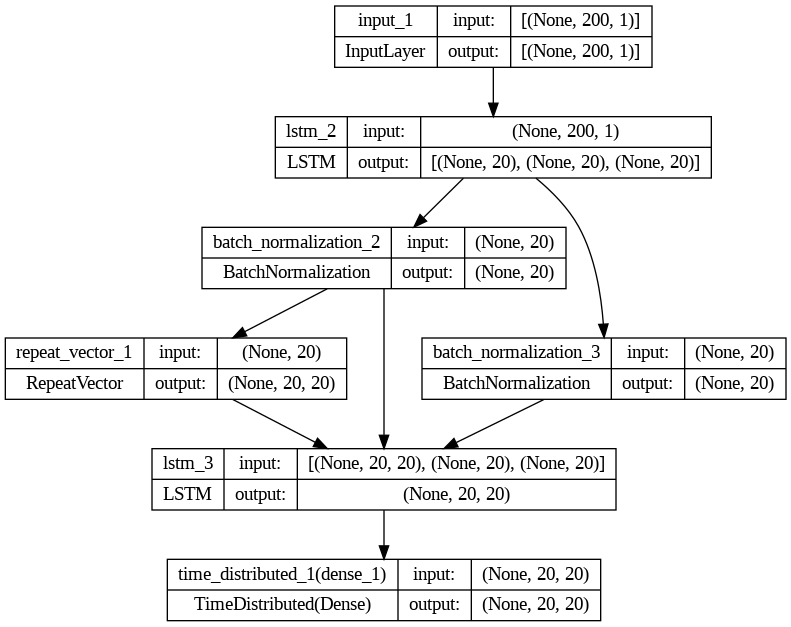

In [48]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [123]:
epc = 30
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history = model.fit(X_input_train[:, :, :1], X_output_train[:, :, :1], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
#model.save('model_forecasting_seq2seq.h5')


Epoch 1/30
55/55 [==============================] - 18s 328ms/step - loss: 0.0219 - mae: 0.1060 - val_loss: 0.0051 - val_mae: 0.0569
Epoch 2/30
55/55 [==============================] - 18s 326ms/step - loss: 0.0062 - mae: 0.0622 - val_loss: 0.0039 - val_mae: 0.0490
Epoch 3/30
55/55 [==============================] - 18s 320ms/step - loss: 0.0045 - mae: 0.0527 - val_loss: 0.0034 - val_mae: 0.0457
Epoch 4/30
55/55 [==============================] - 19s 338ms/step - loss: 0.0041 - mae: 0.0500 - val_loss: 0.0030 - val_mae: 0.0436
Epoch 5/30
55/55 [==============================] - 17s 319ms/step - loss: 0.0039 - mae: 0.0492 - val_loss: 0.0032 - val_mae: 0.0446
Epoch 6/30
55/55 [==============================] - 18s 320ms/step - loss: 0.0037 - mae: 0.0478 - val_loss: 0.0028 - val_mae: 0.0417
Epoch 7/30
55/55 [==============================] - 17s 309ms/step - loss: 0.0035 - mae: 0.0466 - val_loss: 0.0028 - val_mae: 0.0412
Epoch 8/30
55/55 [==============================] - 18s 325ms/step - 

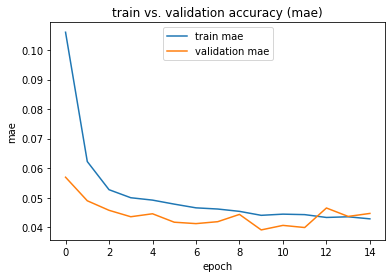

In [124]:
# Training vs Validation MAE
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center')
plt.show()


In [125]:
train_pred_detrend = model.predict(X_input_train[:, :, :1])#*x_train_max[:1]
test_pred_detrend = model.predict(X_input_test[:, :, :1])#*x_train_max[:1]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :1]#*x_train_max[:1]
test_true_detrend = X_output_test[:, :, :1]#*x_train_max[:1]
print(train_true_detrend.shape, test_true_detrend.shape)


94/94 [==============================] - 3s 35ms/step
(6800, 20, 20) (2981, 20, 20)
(6800, 20, 1) (2981, 20, 1)


In [126]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt#[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 1]*x1_trend_param[1] + x1_trend_param[2]
    #dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2)], axis=1)
    print(lb+': {}'.format(data_final[lb].shape))


train_pred: (6800, 20, 1, 20)
train_true: (6800, 20, 1, 1)
test_pred: (2981, 20, 1, 20)
test_true: (2981, 20, 1, 1)


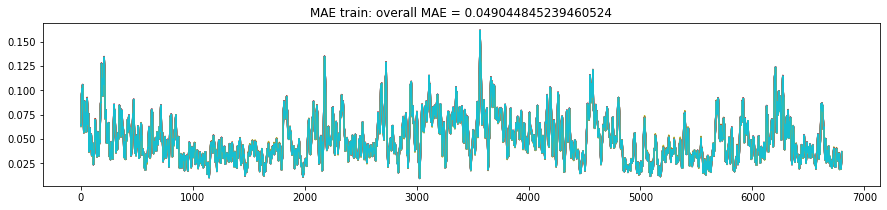

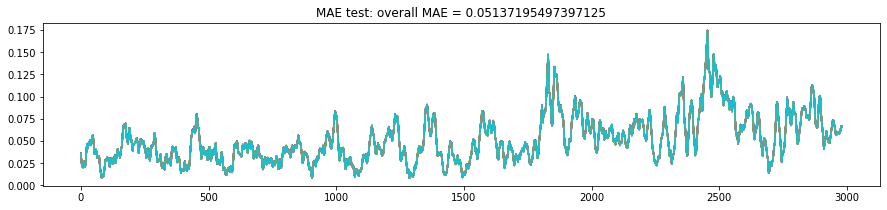

In [127]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()


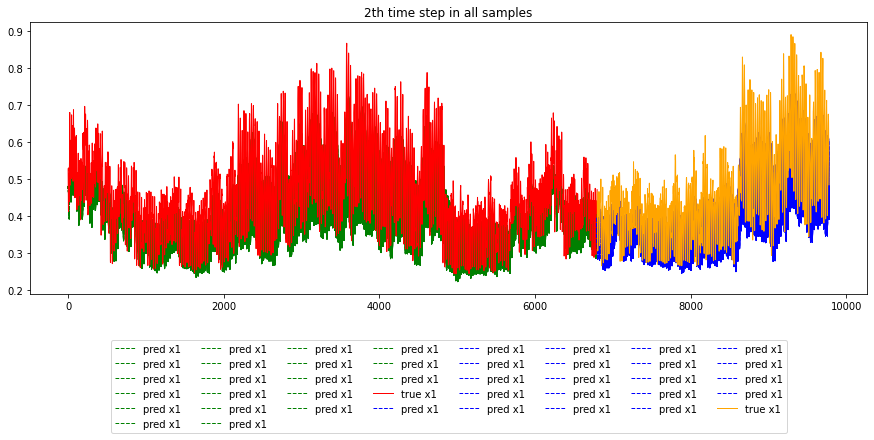

In [128]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()


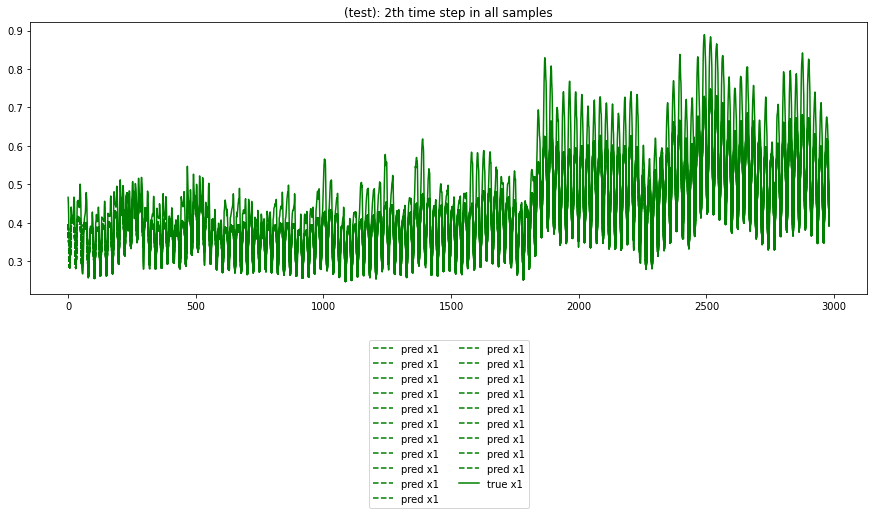

In [129]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1'], ['green']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()



#### Attention Architecture


In [130]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)

decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])

attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)


KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='activation_1/Softmax:0', description="created by layer 'activation_1'")


In [131]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)



In [132]:
decoder_combined_context = concatenate([context, decoder_stack_h])


In [133]:
out = TimeDistributed(Dense(output_train.shape[1]))(decoder_combined_context)


In [134]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 1)]     0           []                               
                                                                                                  
 lstm_9 (LSTM)                  [(None, 200, 20),    1760        ['input_3[0][0]']                
                                 (None, 20),                                                      
                                 (None, 20)]                                                      
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 20)          80          ['lstm_9[0][1]']                 
 rmalization)                                                                               

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [136]:
epc = 50
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
history = model.fit(X_input_train[:, :, :1], X_output_train[:, :, :1], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
#model.save('model_forecasting_seq2seq_attention.h5')


Epoch 1/50
55/55 [==============================] - 18s 325ms/step - loss: 0.0048 - mae: 0.0548 - val_loss: 0.0045 - val_mae: 0.0540
Epoch 2/50
55/55 [==============================] - 17s 305ms/step - loss: 0.0050 - mae: 0.0560 - val_loss: 0.0057 - val_mae: 0.0599
Epoch 3/50
55/55 [==============================] - 18s 327ms/step - loss: 0.0047 - mae: 0.0536 - val_loss: 0.0085 - val_mae: 0.0750
Epoch 4/50
55/55 [==============================] - 17s 316ms/step - loss: 0.0044 - mae: 0.0522 - val_loss: 0.0043 - val_mae: 0.0532
Epoch 5/50
55/55 [==============================] - 19s 345ms/step - loss: 0.0044 - mae: 0.0526 - val_loss: 0.0045 - val_mae: 0.0541
Epoch 6/50
55/55 [==============================] - 17s 303ms/step - loss: 0.0043 - mae: 0.0517 - val_loss: 0.0044 - val_mae: 0.0526
Epoch 7/50
55/55 [==============================] - 17s 312ms/step - loss: 0.0042 - mae: 0.0512 - val_loss: 0.0061 - val_mae: 0.0626
Epoch 8/50
55/55 [==============================] - 17s 318ms/step - 

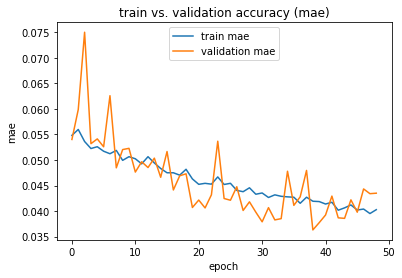

In [137]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center')
plt.show()


In [138]:
train_pred_detrend = model.predict(X_input_train[:, :, :1])#*x_train_max[:1]
test_pred_detrend = model.predict(X_input_test[:, :, :1])#*x_train_max[:1]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :1]#*x_train_max[:1]
test_true_detrend = X_output_test[:, :, :1]#*x_train_max[:1]
print(train_true_detrend.shape, test_true_detrend.shape)
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt#[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 1]*x1_trend_param[1] + x1_trend_param[2]
    #dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2)], axis=1)
    print(lb+': {}'.format(data_final[lb].shape))



94/94 [==============================] - 3s 36ms/step
(6800, 20, 20) (2981, 20, 20)
(6800, 20, 1) (2981, 20, 1)
train_pred: (6800, 20, 1, 20)
train_true: (6800, 20, 1, 1)
test_pred: (2981, 20, 1, 20)
test_true: (2981, 20, 1, 1)


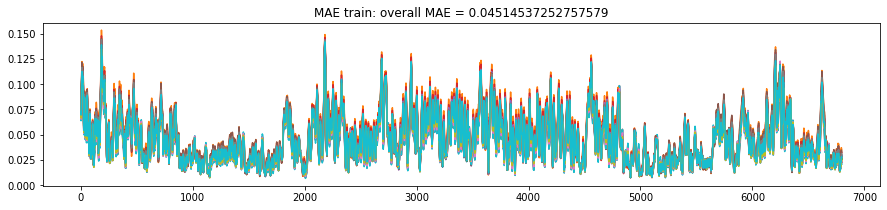

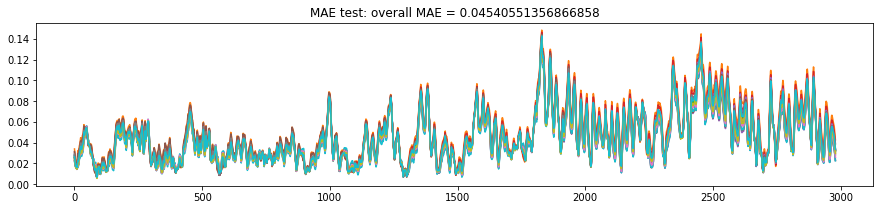

In [139]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()


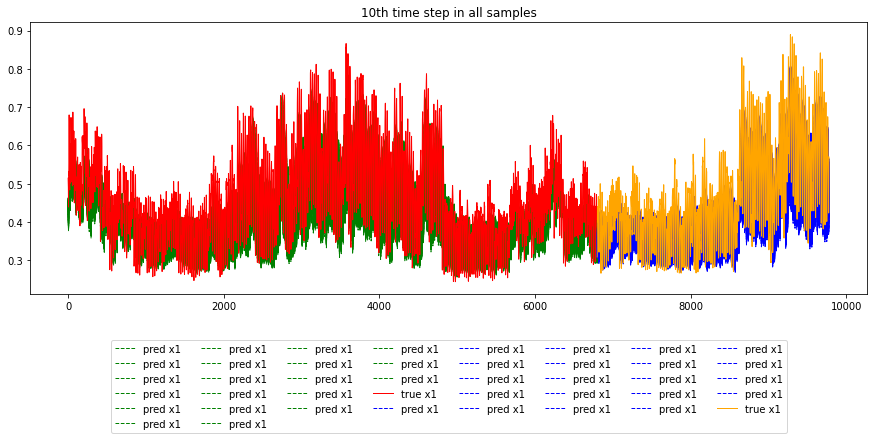

In [140]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()


Overall, both encoder-decoder and attention mechanism does well on the 20 step ahead forecasting. I would also like to explore how it performs on detrended data and how much performance improves after hyperparameter tuning